In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)
cosmo=Planck13

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

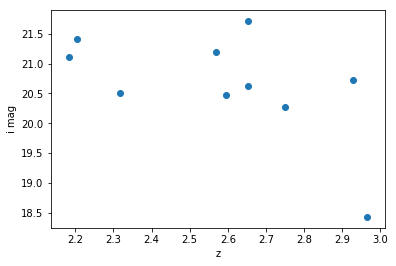

In [3]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 10
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('SDSS-i',1450)
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=cosmo),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('i mag');

In [4]:
# add the fiducial quasar SED model from BOSS DR9, don't add IGM absorption
sedVars = get_BossDr9_model_vars(qsos,wave,0,noforest=True)
qsos.addVars(sedVars)

In [5]:
# need to define photometry in SDSS system in order to calibrate apparent mags
qsos.loadPhotoMap([('SDSS','Legacy'),])

In [6]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.1314493, rms = 0.0821061, |max| = 0.2537216
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0013406, rms = 0.0012099, |max| = 0.0029567


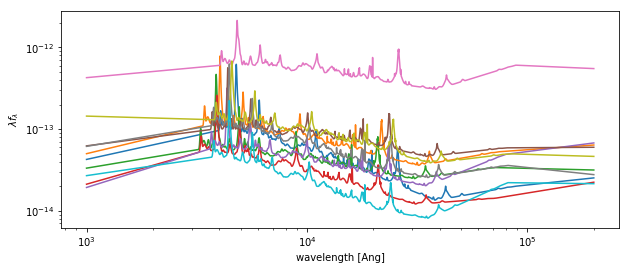

In [7]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$');

In [8]:
# the parameter values for each spectrum
qsos.data

appMag,absMag,z,slopes [5],"emLines [62,3]",synMag [5],synFlux [5]
float64,float64,float64,float64,float64,float64,float64
20.720287652,-24.5727794135,2.92961609282,-1.58861642233 .. -1.2870212367,1033.07292218 .. 303.24260794,21.3312576914 .. 20.7489058194,2.93424871755 .. 5.01692573466
20.4980560182,-24.2154557106,2.31637555458,-1.64409940229 .. -1.19208456779,1034.28048232 .. 268.960336091,20.9467670492 .. 20.2638521968,4.18112527739 .. 7.84258295716
21.1166882673,-23.3552144761,2.18391881168,-1.44831382 .. -0.932824648661,1034.58339786 .. 327.033136504,21.3621911656 .. 20.8674652794,2.85182934655 .. 4.49794238574
21.4155451541,-23.2408261727,2.20456027855,-1.76578967689 .. -1.43931570609,1033.20463834 .. 355.598097107,21.6488482203 .. 21.2353473243,2.19008369488 .. 3.20524381109
21.194051494,-23.7970696995,2.56772502908,-1.8438812642 .. -1.35015434714,1033.95229433 .. 310.273326778,21.7326535415 .. 20.9342447193,2.02739599116 .. 4.22962741446
20.4754415088,-24.4423085904,2.59554470298,-1.35328588615 .. -1.01809551637,1033.92017183 .. 266.72405819,21.1494675012 .. 20.1889045486,3.46906949083 .. 8.40307385467
18.4267606044,-26.7400799535,2.96451451974,-1.24793481208 .. -0.881804741132,1033.74487433 .. 299.601671168,19.2980365399 .. 18.3397514618,19.0890969662 .. 46.1423187835
20.6294835992,-24.4863993897,2.65317709687,-1.44438442229 .. -0.710415428268,1033.20886475 .. 289.882115805,21.0527795025 .. 20.4819739644,3.7921734997 .. 6.41520315791
20.2775454313,-24.786153064,2.74890663753,-0.920838176468 .. -0.91653782229,1034.38945522 .. 338.350717604,20.8924620059 .. 20.1533610937,4.39556996949 .. 8.68271532934


In [9]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [10]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')